# essais article 2 & 3 avec le corps du mobile net modifié (+ la t^te value modifiée)

In [ ]:
from google.colab import drive # Import a library named google.colab
drive.mount('/content/drive', force_remount=True) # mount the content to the directory `/content/drive`

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, Dense
from tensorflow.keras.layers import Concatenate, Add, ReLU, BatchNormalization
from tensorflow.keras.layers import AvgPool2D, MaxPool2D, GlobalAveragePooling2D, Reshape,ZeroPadding2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Permute, Lambda, Flatten, Activation
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install pybind11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 kB 8.5 MB/s eta 0:00:00


In [ ]:
!wget https://www.lamsade.dauphine.fr/~cazenave/project2022.zip
!unzip project2022.zip

--2023-06-16 10:51:40--  https://www.lamsade.dauphine.fr/~cazenave/project2022.zip
Resolving www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)... 193.48.71.250
Connecting to www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138884468 (132M) [application/zip]
Saving to: ‘project2022.zip’

project2022.zip     100%[===================>] 132.45M  21.4MB/s    in 7.1s    

2023-06-16 10:51:48 (18.7 MB/s) - ‘project2022.zip’ saved [138884468/138884468]

Archive:  project2022.zip
  inflating: Board.h                 
  inflating: Game.h                  
  inflating: Rzone.h                 
  inflating: compile.sh              
  inflating: compileMAC.sh           
  inflating: games.data              
  inflating: golois.cpp              
  inflating: golois.cpython-310-x86_64-linux-gnu.so  
  inflating: golois.cpython-37m-x86_64-linux-gnu.so  
  inflating: golois.cpython-38-x86_64-linux-gnu.so  
  inflat

In [ ]:
!c++ -O3 -Wall -shared -std=c++11 -fsized-deallocation -fPIC `python3.10 -m pybind11 --includes` golois.cpp -o golois$(python3.10-config --extension-suffix)

In [ ]:
import gc
import golois

In [ ]:
planes = 31
moves = 361
N = 30000
epochs = 100
batch = 1024
filters = 32 #passer à 64et plus fait exploser le nbre de paramètres / on ne respecte plus la limite des 100K paramètres

In [ ]:
#artcile sur Squeeze and Excitation
def SE_block(t,filters,ratio=16):
  se_shape = (1,1,filters)
  se = GlobalAveragePooling2D()(t)
  se = Reshape(se_shape)(se)
  se = layers.Dense(filters//ratio,activation='relu',use_bias = False)(se)
  se = layers.Dense(filters,activation='sigmoid',use_bias = False)(se)
  x = layers.Multiply()([t,se])
  return x


def SE Block(t , filters , ratio =16): se shape = (1, 1, filters )
se = se = se =
se =
GlobalAveragePooling2D ()( t ) Reshape(se shape)(se) Dense( filters // ratio ,
activation=’relu’,
use bias=False)(se) Dense( filters ,
activation=’sigmoid ’ ,
use bias=False)(se) x = multiply([t,se])
return x

In [ ]:
#ratio = 16

#input = keras.Input(shape=(19, 19, planes), name='board')
#x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input)

#output=SE_block(x,filters)

#Ind=x
#se_shape = (1,1,filters)
#se = GlobalAveragePooling2D()(x)
#se = Reshape(se_shape)(se)
#se = layers.Dense(filters//ratio,activation='relu',use_bias = False)(se)
#se = layers.Dense(filters,activation='sigmoid',use_bias = False)(se)
#x = layers.Multiply()([Ind,se])


#model = keras.Model(inputs=input, outputs=output)

In [ ]:
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
#block res net de référence (mobile net)
def bottleneck_block(x, expand=6*filters, squeeze=filters):
  m = layers.Conv2D(expand, (1,1), use_bias = False)(x)
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu')(m)
  m = layers.DepthwiseConv2D((3,3), padding='same', use_bias = False)(m)
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu')(m)
  m = layers.Conv2D(squeeze, (1,1), use_bias = False)(m)
  m = layers.BatchNormalization()(m)

  return layers.Add()([m, x]) #ici on rajoute l'entrée du bloc à l'entrée du bloc


In [ ]:
#block Inverted Residual Block modifié
def bottleneck_block_bis(x, expand=6*filters, squeeze=filters):
  m = layers.Conv2D(expand, (1,1), use_bias = False)(x)
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu')(m)
  m = layers.DepthwiseConv2D((3,3), padding='same', use_bias = False)(m)
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu')(m)
  m = layers.Conv2D(squeeze, (1,1), use_bias = False)(m)
  m = layers.BatchNormalization()(m)

  m=SE_block(m,filters)
  return layers.Add()([m, x]) #ici on rajoute l'entrée du bloc à l'entrée du bloc


In [ ]:
#ne PAS OUBLIER  de rejouer qd N change ou changement de moèdle !!
input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype ('float32')

policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical (policy)

value = np.random.randint(2, size=(N,))
value = value.astype ('float32')

end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype ('float32')

groups = np.zeros((N, 19, 19, 1))
groups = groups.astype ('float32')

print ("getValidation", flush = True)
golois.getValidation (input_data, policy, value, end)


getValidation


In [ ]:
#partie pour appeler les différentes architectures de Residual Network

#couche d'input
input = keras.Input(shape=(19, 19, planes), name='board')
x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input)

In [ ]:
#couches cachées différents modèles de RN
for i in range (6):
  x = bottleneck_block_bis(x)

In [ ]:
#non utilisé dans cette version

#Call back qui monitore une valeur par exemple value_loss  et réduit le LR si pas d'amélioration constatée
#min_lr = lower bound on the learning rate
#In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing
#patience: number of epochs with no improvement after which learning rate will be reduced.

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='value_mse', mode='min',factor=0.2,
                              patience=5, min_delta=0.005,verbose=1)

In [ ]:
#essai de fonctionnement tensorBoard
tensorboard =tf.keras.callbacks.TensorBoard(log_dir="/content/drive/MyDrive/colab_slim",histogram_freq=1)

In [ ]:
#enregistrement des ttes epochs dans un fichier log
csv_logger = tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projet_DP/ModelesH5/Variante_Residual_Go_Article2&3/training_article2&3.log',append=True)

In [ ]:
#couches de sortie policy
policy_head = layers.Conv2D(1, 1, activation='relu', padding='same',xkernel_regularizer=regularizers.l2(0.001))(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)

#value_head=ZeroPadding2D(padding=(1,1))(x)
value_head=AvgPool2D(pool_size=(2,2),strides=2,padding='same')(x)
value_head=ZeroPadding2D(padding=(1,1))(value_head)
value_head=AvgPool2D(pool_size=(2,2),strides=2,padding='same')(value_head)
value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False)(value_head)
value_head = layers.Flatten()(value_head)

value_head = layers.Dense(50, activation='relu')(value_head)
value_head = layers.Dense(9, activation='relu')(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value')(value_head)


model = keras.Model(inputs=input, outputs=[policy_head, value_head])

model.summary ()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board (InputLayer)             [(None, 19, 19, 31)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 19, 19, 32)   1024        ['board[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 19, 19, 192)  6144        ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 19, 19, 192)  768        ['conv2d_1[0][0]']           

In [ ]:
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projet_DP/ModelesH5/Variante_Residual_Go_Article2&3/SlimSEM21_Variante_Residual_GO_Article2&3_v01_500Epochs.h5')

In [ ]:
#compile initial
#model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
#              loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
#              loss_weights={'policy' : 1.0, 'value' : 1.0},
#              metrics={'policy': 'categorical_accuracy', 'value': 'mse'})

opt = keras.optimizers.Adam(learning_rate=0.0008)
model.compile(optimizer=opt,
              loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
              loss_weights={'policy' : 1.0, 'value' : 9.0},
              metrics={'policy': 'categorical_accuracy', 'value': 'mse'})


loss_train=[]
policy_loss_train=[]
value_loss_train=[]
policy_accuracy_train=[]
value_mse_train=[]

for i in range (1, epochs + 1):
    print ('epoch ' + str (i))
    golois.getBatch (input_data, policy, value, end, groups, i * N)
    history = model.fit(input_data,
                        {'policy': policy, 'value': value},
                        epochs=1, batch_size=batch,verbose=1,callbacks=[reduce_lr,csv_logger])

    loss_train.append(history.history['loss'])
    policy_loss_train.append(history.history['policy_loss'])
    value_loss_train.append(history.history['value_loss'])
    policy_accuracy_train.append(history.history['policy_categorical_accuracy'])
    value_mse_train.append(history.history['value_mse'])

    if (i % 2 == 0):
        gc.collect () #garbage collector
    if (i % 100 == 0):
        golois.getValidation (input_data, policy, value, end)
        val = model.evaluate (input_data,
                              [policy, value], verbose = 1, batch_size=batch)
        print ("val =", val)
        model.save ('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projet_DP/ModelesH5/Variante_Residual_Go_Article2&3/SlimSEM21_Variante_Residual_GO_Article2&3_v01_{}Epochs.h5'.format(i+500))



epoch 1
30/30 [==============================] - 43s 560ms/step - loss: 7.0362 - policy_loss: 2.1239 - value_loss: 0.5458 - policy_categorical_accuracy: 0.4299 - value_mse: 0.0600 - lr: 8.0000e-04
epoch 2
30/30 [==============================] - 17s 550ms/step - loss: 7.0409 - policy_loss: 2.1238 - value_loss: 0.5463 - policy_categorical_accuracy: 0.4284 - value_mse: 0.0600 - lr: 8.0000e-04
epoch 3
30/30 [==============================] - 16s 544ms/step - loss: 7.0380 - policy_loss: 2.1139 - value_loss: 0.5471 - policy_categorical_accuracy: 0.4351 - value_mse: 0.0608 - lr: 8.0000e-04
epoch 4
30/30 [==============================] - 16s 545ms/step - loss: 7.0535 - policy_loss: 2.1215 - value_loss: 0.5480 - policy_categorical_accuracy: 0.4334 - value_mse: 0.0603 - lr: 8.0000e-04
epoch 5
30/30 [==============================] - 16s 541ms/step - loss: 7.0713 - policy_loss: 2.1354 - value_loss: 0.5484 - policy_categorical_accuracy: 0.4308 - value_mse: 0.0607 - lr: 8.0000e-04
epoch 6
30/30 [

In [ ]:
#essai 1 avec modif du corps princiaple article 3 et  tetes suivant article 2 sur average pooling 2D
#avec  98,3 K paramètres (6 boucles de Mobile Net modifiée + new têtes value et policy
#new optimizer ADAM(learning_rate=0.01 pas de momentum mais adaptatif
#loss_weights={'policy' : 1.0, 'value' : 9.0} ?
#pas de régul#N=30K
#Batch size=1024
#epoch =500


#les 100 premières epcohs LR = 0,01
#les epochs de 101 à 200, LR= 0,008
#les epochs de 201 à 300, LR= 0,006
#les epochs de 301 à 400, LR= 0,004
#les epochs de 401 à 500, LR= 0,001
#les epochs de 501 à 600, LR= 0,0008


#val à epochs =100 = [8.124777793884277, 2.5031914710998535, 0.6246204376220703, 0.38690000772476196, 0.08942416310310364]
#val à epochs =200 = [7.677131175994873, 2.283867120742798, 0.5992516279220581, 0.4053666591644287, 0.0800807997584343]
#val à epochs =300 = [7.406951904296875, 2.206000328063965, 0.5778834819793701, 0.4192666709423065, 0.07156974077224731]
#val à epochs =400 = [7.402581691741943, 2.1690433025360107, 0.5815041661262512, 0.4248333275318146, 0.07307418435811996]
#val à epcohs = 500 = [7.207860469818115, 2.129920482635498, 0.5642154812812805, 0.430400013923645, 0.06710759550333023
#val à epcohs = 600 = 7.176981449127197, 2.126734733581543, 0.561138391494751, 0.43076667189598083, 0.06598347425460815]


#intéressant à partir de 600 epochs les accuracy et mse ne bougent plus qu'au delà de e-3 pour accuracy et e-4 pour mse

#pour rappel le meilleur résultat obtenu article 2 / 400 epochs / LR variable et batch szie à 256 + N =30K
#val à epochs =400 = [7.779914379119873, 2.2341439723968506, 0.6161968111991882, 0.41856667399406433, 0.08675386756658554


In [ ]:
#%cd /content/drive/MyDrive/Colab Notebooks/Deep Learning/Projet_DP/ModelesH5/Variante_Residual_Go_Article3/
%ls -la

total 6195
-rw------- 1 root root 1572544 May 29 13:59 SlimSEM21_Variante_Residual_GO_Article3_v01_100Epochs.h5
-rw------- 1 root root 1572544 May 29 16:22 SlimSEM21_Variante_Residual_GO_Article3_v01_300Epochs.h5
-rw------- 1 root root 1572544 May 30 18:04 SlimSEM21_Variante_Residual_GO_Article3_v01_400Epochs.h5
-rw------- 1 root root 1572544 May 30 18:50 SlimSEM21_Variante_Residual_GO_Article3_v01_500Epochs.h5
-rw------- 1 root root   51809 May 30 18:50 training_article3.log


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projet_DP/ModelesH5/Variante_Residual_Go_Article2&3/Réseau_en_largeur'

/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projet_DP/ModelesH5/Variante_Residual_Go_Article2&3/Réseau_en_largeur


In [ ]:
%ls -la

total 9093
-rw------- 1 root root 1466216 Jun  6 03:05 SlimSEM23_Variante_Residual_GO_Article2_3_v02__100Epochs.h5
-rw------- 1 root root 1466216 Jun  6 03:53 SlimSEM23_Variante_Residual_GO_Article2_3_v02__200Epochs.h5
-rw------- 1 root root 1466216 Jun  6 04:40 SlimSEM23_Variante_Residual_GO_Article2_3_v02__300Epochs.h5
-rw------- 1 root root 1466216 Jun  7 04:06 SlimSEM23_Variante_Residual_GO_Article2_3_v02__400Epochs.h5
-rw------- 1 root root 1466216 Jun  7 04:50 SlimSEM23_Variante_Residual_GO_Article2_3_v02__500Epochs.h5
-rw------- 1 root root 1466216 Jun  7 05:39 SlimSEM23_Variante_Residual_GO_Article2_3_v02__600Epochs.h5
-rw------- 1 root root  115462 Jun  7 05:39 training_article2_3_v2.log
-rw------- 1 root root  396462 Jun  7 05:42 Variante_Residual_Article2_3_GO.ipynb


In [ ]:
import pandas as pd
df_P= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projet_DP/ModelesH5/Variante_Residual_Go_Article2&3/Réseau_en_profondeur/training_article2&3.log')

In [ ]:
df_P.iloc[400]

Unnamed: 0                     400.000000
epoch                            0.000000
loss                             7.135497
lr                               0.001000
policy_categorical_accuracy      0.423767
policy_loss                      2.154085
value_loss                       0.553490
value_mse                        0.062766
Name: 400, dtype: float64

In [ ]:
df_P.columns

Index(['Unnamed: 0', 'epoch', 'loss', 'lr', 'policy_categorical_accuracy',
       'policy_loss', 'value_loss', 'value_mse'],
      dtype='object')

In [ ]:
df_L= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projet_DP/ModelesH5/Variante_Residual_Go_Article2&3/Réseau_en_largeur/training_article2_3_v2.log')

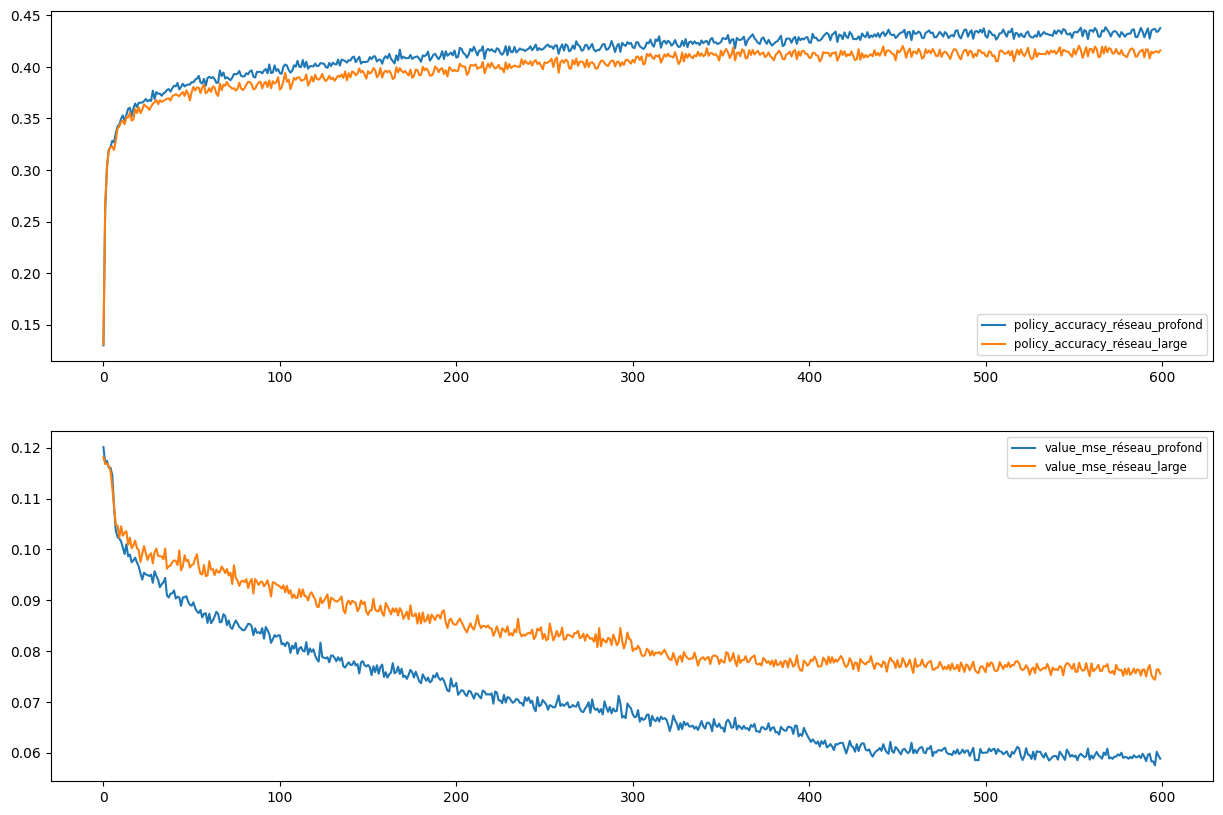

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')
# legend([plot1], "title", prop=fontP)

#plt.plot(metrics_df.iloc[:, metrics_df.columns.get_level_values(1)=='val_loss'])
fig, ax = plt.subplots(2, figsize = (15,10))
df_P.loc[:,'policy_categorical_accuracy'].plot(ax=ax[0],label="policy_accuracy_réseau_profond")
df_L.loc[:,'policy_categorical_accuracy'].plot(ax=ax[0],label="policy_accuracy_réseau_large")
df_P.loc[:,'value_mse'].plot(ax=ax[1],label="value_mse_réseau_profond")
df_L.loc[:,'value_mse'].plot(ax=ax[1],label="value_mse_réseau_large")

ax[0].legend(prop=fontP, loc='lower right')
ax[1].legend(prop=fontP, loc='upper right')

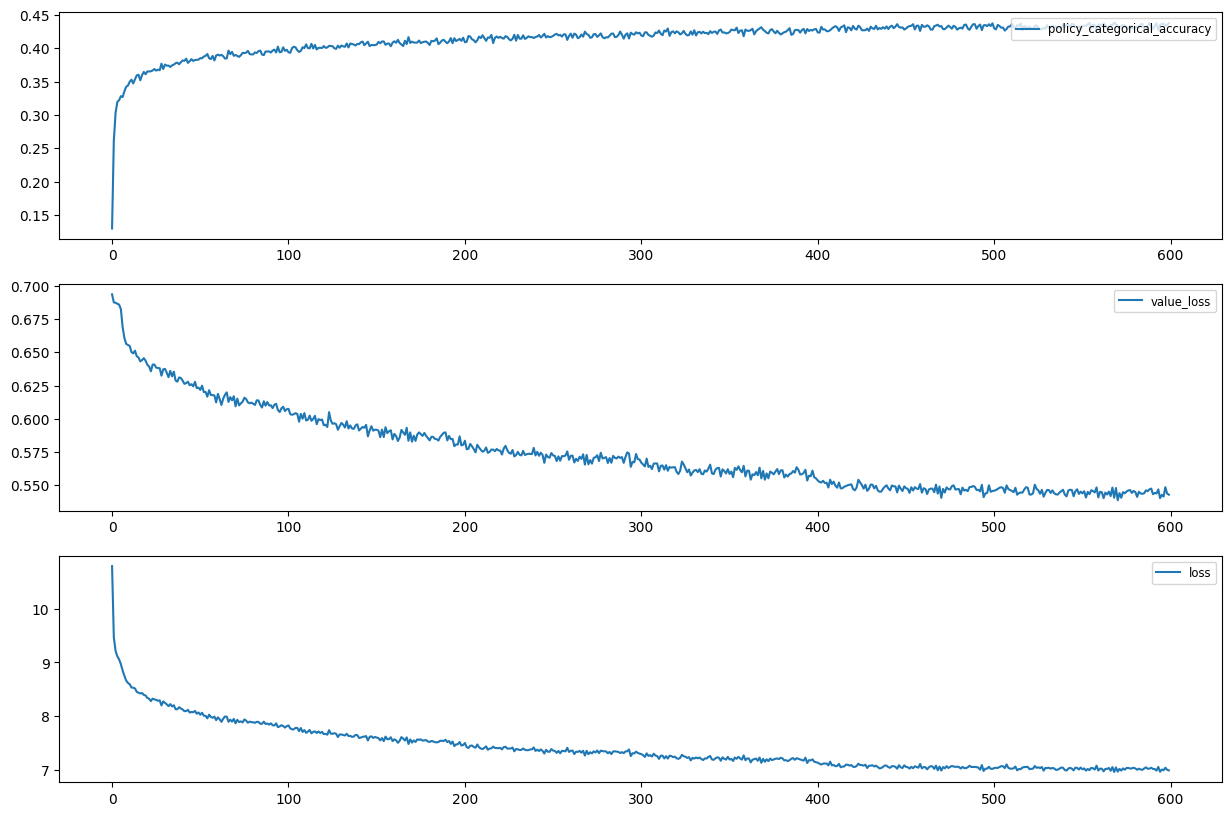

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')
# legend([plot1], "title", prop=fontP)

#plt.plot(metrics_df.iloc[:, metrics_df.columns.get_level_values(1)=='val_loss'])
fig, ax = plt.subplots(3, figsize = (15,10))
df_P.loc[:,'policy_categorical_accuracy'].plot(ax=ax[0])
df_P.loc[:,'value_loss'].plot(ax=ax[1])
df_P.loc[:,'loss'].plot(ax=ax[2])

ax[0].legend(prop=fontP, loc='upper right')
ax[1].legend(prop=fontP, loc='upper right')
ax[2].legend(prop=fontP, loc='upper right')